# Imports

In [25]:
import torch
import torch.nn as nn
import torch.utils
import torch.utils.checkpoint
from torch.utils.checkpoint import checkpoint_sequential, checkpoint, set_checkpoint_early_stop
from collections import defaultdict
from math import ceil
import torch
import torch.nn as nn
import torch
from torchvision import datasets, transforms
import random
import numpy as np
import os
import argparse
import time
import resource
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import threading

# Graph

In [4]:

class Node(nn.Module):
    def __init__(self, name, module):
        super(Node, self).__init__()
        self.name = name
        self.module = module
        self.inputs = []

    def forward(self, x):
        # print(f"Node {self.name} input shape: {x.shape if isinstance(x, torch.Tensor) else [i.shape for i in x]}")
        output = self.module(x)

        return output


class Graph(nn.Module):
    def __init__(self, segment_size=3):
        super(Graph, self, ).__init__()

        self.nodes = nn.ModuleDict()
        self.edges = defaultdict(list)
        self.final = None
        self.segment_size = segment_size
        self.dp = {}
        self.checkpoints = {}

    def add_node(self, node):
        self.nodes[node.name] = node

    def add_final_node(self, node):
        self.add_node(node)
        self.final = node.name

    def add_edge(self, from_node, to_node):
        to_node = self.nodes[to_node]
        to_node.inputs.append(from_node)
        self.edges[from_node].append(to_node)


    def run_with_checkpoints(self, functions, segments, input):

        def run_function(start, end, functions):
            def forward(input):
                for j in range(start, end + 1):
                    input = functions[j](input)

                return input

            return forward

        segments = min(segments, len(functions))
        segment_size = len(functions) // segments


        end = -1


        for start in range(0, segment_size * (segments - 1), segment_size):
            end = start + segment_size - 1

            input.requires_grad_()
            input = checkpoint(
                run_function(start, end, functions),
                input,
                use_reentrant=False,
            )




        return run_function(end + 1, len(functions) - 1, functions)(input)

    def forward(self, input):

        self.nodes['x'] = Node('x', lambda x: x)

        def dfs(node):
            if node.name in self.dp:
                return self.dp[node.name]

            # caso onde não tem inputs
            if not node.inputs:
                return []

            # caso onde tem apenas um input
            if len(node.inputs) == 1:
                prev = self.nodes[node.inputs[0]]
                functions = dfs(prev)

                self.dp[node.name] = functions + [lambda x:  node(x)]
                return self.dp[node.name]

            # caso onde tem mais de um input
            else:
                childrens = {}
                for prev in node.inputs:
                    prev = self.nodes[prev]
                    functions = dfs(prev)
                    childrens[prev.name] = functions

                def _func(x):
                    inputs = {}
                    for key in node.inputs:
                        if len(childrens[key]) > 1:
                            segments = ceil(len(childrens[key]) /  self.segment_size)
                            out = self.run_with_checkpoints(childrens[key], segments, x)

                        else:
                            out = childrens[key][0](x)
                        inputs[key] = out

                    inputs = [inputs[key] for key in node.inputs]
                    return  node(inputs)

                self.dp[node.name] = [_func]
                return self.dp[node.name]

        functions = dfs(self.nodes[self.final])
        segments = ceil(len(functions) / self.segment_size )

        out = self.run_with_checkpoints(functions, segments, input)
        return out


# Models

In [5]:


class Concat(nn.Module):
    def __init__(self, dim=1):
        super(Concat, self).__init__()
        self.dim = dim

    def forward(self, inputs):
        return torch.cat(inputs, dim=self.dim)

class Block(nn.Module):
    def __init__(self, input_size, hidden_size=64 ):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input_size, hidden_size * 2, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size * 2, hidden_size, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class ConcatBlock(nn.Module):
    def __init__(self, hidden_size, dim=1, n_inputs=2):
        super(ConcatBlock, self).__init__()
        self.concat = Concat(dim)
        self.block = Block(hidden_size * n_inputs, hidden_size)

    def forward(self, x):
        return self.block(self.concat(x))

class LinearBlock(nn.Module):
    def __init__(self, input_shape, hidden_size=64):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(input_shape, hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class NN_Sequential(nn.Module):
    def __init__(self, segment_size=3, hidden_size=16):
        super(NN_Sequential, self).__init__()

        self.graph = Graph(segment_size)
        self.hidden_size = hidden_size

        self.graph.add_node(Node('1', nn.Conv2d(1, self.hidden_size, kernel_size=3, stride=1, padding=1)))

        for i in range(2, 7):
            self.graph.add_node(Node(str(i), nn.Conv2d(self.hidden_size, self.hidden_size, kernel_size=3, stride=1, padding=1)))

        final_layers = [
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(self.hidden_size, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128*7*7, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
        ]

        for i, layer in enumerate(final_layers):
            self.graph.add_node(Node(str(i+7), layer))

        self.graph.add_final_node(Node(str(len(final_layers)+7), nn.Linear(self.hidden_size, 10)))

        self.graph.add_edge('x', '1')

        for i in range(1, len(self.graph.nodes)):
            self.graph.add_edge(str(i), str(i+1))

    def forward(self, x):
        x.requires_grad_()
        return self.graph.forward(x)

    def forward_without_checkpoint(self, x):
        x.requires_grad_()
        for i in range(1, len(self.graph.nodes) + 1):
            x = self.graph.nodes[str(i)].module(x)
        return x



class NN_Graph(nn.Module):
    def __init__(self, segment_size=3, hidden_size=16):
        super(NN_Graph, self).__init__()

        self.graph = Graph(segment_size)
        self.hidden_size = hidden_size

        # Nodes
        self.graph.add_node(Node('1', nn.Conv2d(1, self.hidden_size, kernel_size=3, stride=1, padding=1)))
        self.graph.add_node(Node("1'", nn.Conv2d(1, self.hidden_size, kernel_size=3, stride=1, padding=1)))

        concat_nodes = {5:3, 9:3}

        for i in range(2, 10):
            if i in concat_nodes:
                self.graph.add_node(Node(f"{i}", ConcatBlock(self.hidden_size, n_inputs=concat_nodes[i])))
            else:
                self.graph.add_node(Node(f"{i}", Block(self.hidden_size, hidden_size=self.hidden_size)))
            self.graph.add_node(Node(f"{i}'", Block(self.hidden_size, hidden_size=self.hidden_size)))

        for i in range(10, 15):
            self.graph.add_node(Node(f"{i}", Block(self.hidden_size, hidden_size=self.hidden_size)))

        self.graph.add_node(Node(str(15), nn.Flatten()))
        self.graph.add_final_node(Node(str(16), nn.Linear(self.hidden_size * 28 * 28, 10)))

        # Edges
        self.graph.add_edge('x', '1')
        self.graph.add_edge('x', "1'")

        for i in range(1, 9):
            self.graph.add_edge(f"{i}",  f"{i+1}")
            self.graph.add_edge(f"{i}'", f"{i+1}'")

        for i in range(9, 16):
            self.graph.add_edge(f"{i}", f"{i+1}")


        # Residuals

        self.graph.add_edge(f"{5}'",  f"{5}")
        self.graph.add_edge(f"{3}",  f"{5}")


        self.graph.add_edge(f"{9}'",  f"{9}")
        self.graph.add_edge(f"{7}",  f"{9}")






    def forward(self, x):
        x.requires_grad_()
        return self.graph.forward(x)

    def forward_without_checkpoint(self, x):
        x.requires_grad_()

        inputs = {'x' : x}
        for i in range(1, 17):
            node = str(i)
            node_ = str(i) + "'"
            if node_ in self.graph.nodes:
                node_ = self.graph.nodes[str(i) + "'"]
                inputs[node_.name] = node_.module([inputs[input] for input in node_.inputs] if len(node_.inputs) > 1 else inputs[node_.inputs[0]])
            node = self.graph.nodes[str(i)]
            inputs[node.name] = node.module([inputs[input] for input in node.inputs] if len(node.inputs) > 1 else inputs[node.inputs[0]])

        return inputs[self.graph.final]

# Execution

In [6]:


# Set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


def train(model, hidden_size, segment_size):
    device = torch.device("cpu")

    if model == 'graph':
        model = NN_Graph(segment_size, hidden_size).to(device)
    else:
        model = NN_Sequential(segment_size, hidden_size).to(device)


    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            data.requires_grad_()

            if segment_size <= 1:
                output = model.forward_without_checkpoint(data)

            else:
                output =  model(data)


            loss = nn.CrossEntropyLoss()(output, target)

            torch.autograd.backward(loss)
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            break





def main(stats_path, model, segment_size, hidden_size):
    # Run the train() function
    start_time = time.time()
    train(model, hidden_size, segment_size)
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    peak = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024
    print(f"Peak memory usage: {peak} MB")
    with open(stats_path, 'a+') as f:
        f.write(f"{model},{segment_size},{hidden_size},{peak},{elapsed_time:.2f}\n")


transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 52966333.03it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1768559.20it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13935125.69it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7175340.40it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
path = './stats.csv'

with open(path, 'w') as f:
        f.write(f"model,segment_size,hidden_size,peak,time\n")


In [ ]:
# Para gerar os graficos é necessários rodar esse celula com parâmetros variaveis, mas para isso é necessário reiniciar o colab
# Isto se da pelo fato do colab ser um ambiente interativo, assim o pico de mémoria fica salva na sessão e não é possível salvar o pico de cada execução

main('./stats.csv', 'graph', 3, 12)

# main('./stats.csv', 'sequential', 3, 12)

# Plots

In [26]:
df = pd.read_csv('./stats.csv')

In [ ]:
df.head()

In [28]:
df['peak'].replace('OM', 'inf', inplace=True)
df['peak'] = df['peak'].astype(float)

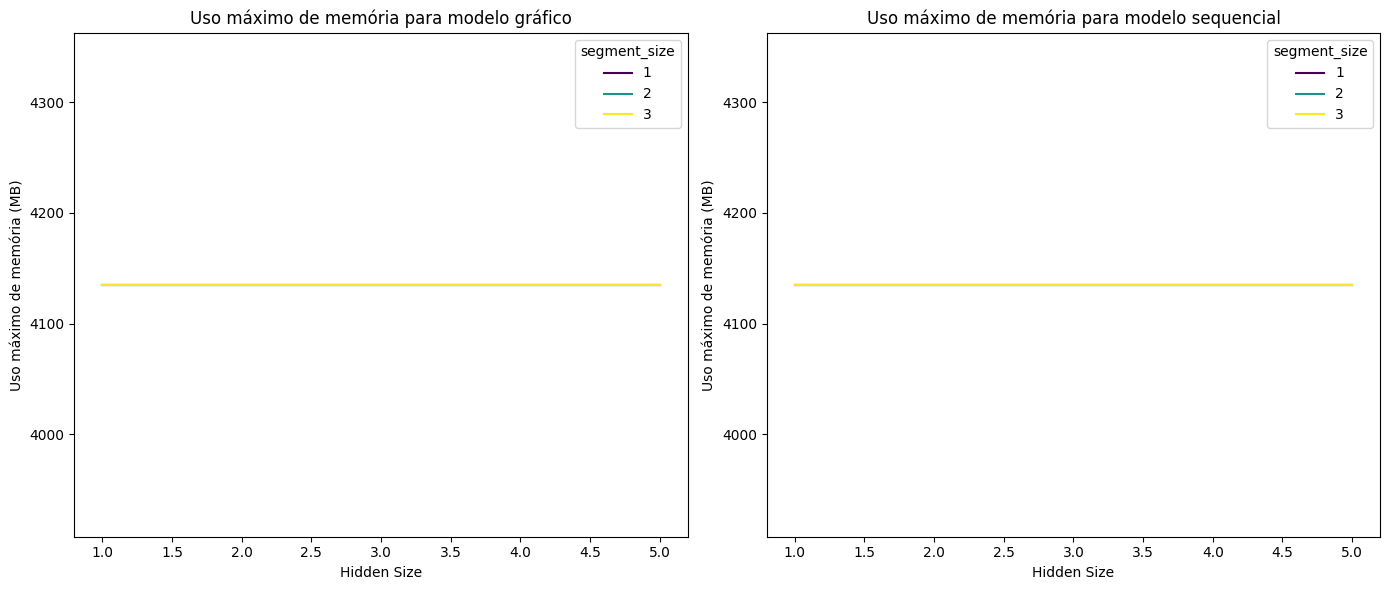

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the 'graph' model
sns.lineplot(data=df.query("model == 'graph'"), x='hidden_size', y='peak', hue='segment_size', palette='viridis', ax=axes[0])
axes[0].set_title('Uso máximo de memória para modelo gráfico')
axes[0].set_xlabel('Hidden Size')
axes[0].set_ylabel('Uso máximo de memória (MB)')

# Plot for the 'sequential' model
sns.lineplot(data=df.query("model == 'sequential'"), x='hidden_size', y='peak', hue='segment_size', palette='viridis', ax=axes[1])
axes[1].set_title('Uso máximo de memória para modelo sequencial')
axes[1].set_xlabel('Hidden Size')
axes[1].set_ylabel('Uso máximo de memória (MB)')
# Show the plot
plt.tight_layout()
plt.show()

In [32]:
df['time'].replace(0, float('inf'), inplace=True)

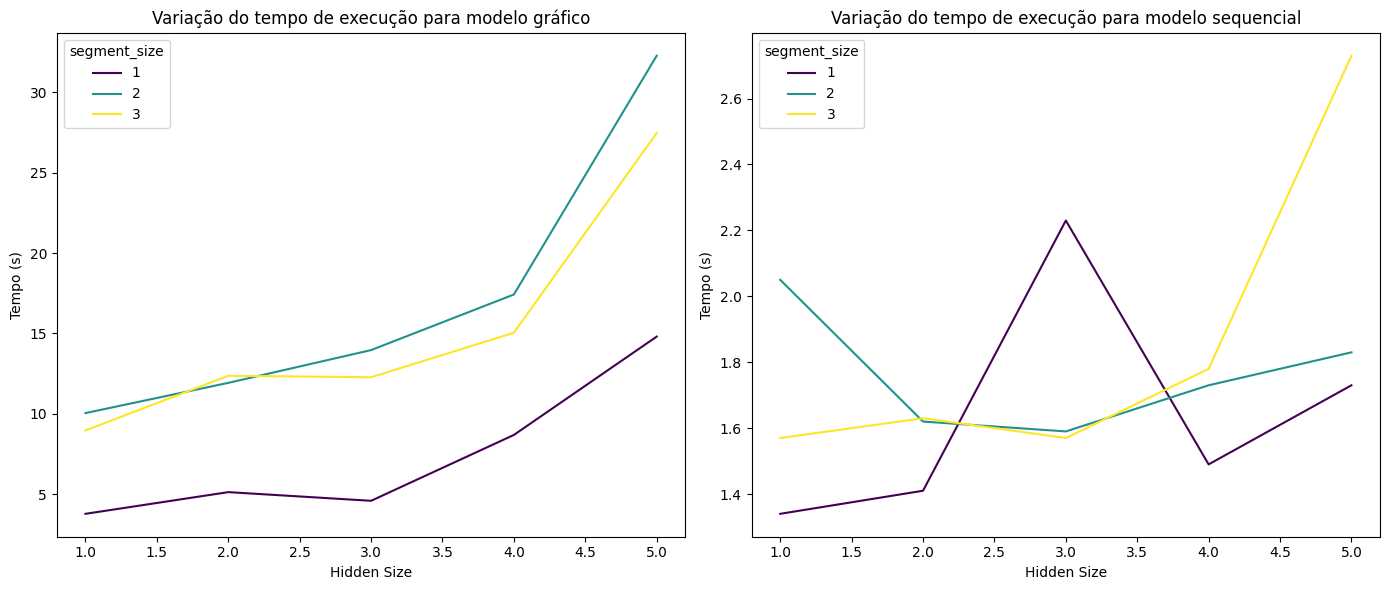

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the 'graph' model
sns.lineplot(data=df.query("model == 'graph'"), x='hidden_size', y='time', hue='segment_size', palette='viridis', ax=axes[0])
axes[0].set_title('Variação do tempo de execução para modelo gráfico')
axes[0].set_xlabel('Hidden Size')
axes[0].set_ylabel('Tempo (s)')


# Plot for the 'sequential' model
sns.lineplot(data=df.query("model == 'sequential'"), x='hidden_size', y='time', hue='segment_size', palette='viridis', ax=axes[1])
axes[1].set_title('Variação do tempo de execução para modelo sequencial')
axes[1].set_xlabel('Hidden Size')
axes[1].set_ylabel('Tempo (s)')

# Show the plot
plt.tight_layout()

plt.show()